A robust model for fake news detection will be built.The file used to build this model contains the tittle of the news article, its summary and a label to indicate if its fake or not with 0 indicating fake news and 1 indicating real news.



In [ ]:
# importing the necessary libraries required to build the model
import sklearn
import re
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from nltk.tokenize import word_tokenize
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from nltk.tokenize import wordpunct_tokenize
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Data Acquisition

The file was in a csv format. Once the file was opened using pandas, the first 5 rows of the file were displayed. As shown below, the file contained the title, text and label columns. the Unnamed:0 is the file's index column.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


The dataset has a total of 72,134 rows and 4 columns

In [ ]:
# Displaying the number or rows and column of the dataset
df.shape

(72134, 4)

# Data Exploration

Since the dataset is large, we will access the most important information on the dataset using the info() function. This shows the datatypes of each column as well as the non-null entries. From this we can tell that both the tittle and the text column contain null values when comparing the total number of rows with non-null values to that of the whole dataset.

In [ ]:
#Accessing the most important information on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


Since some columns contain some missing data, those columns will be discarded, specially the 'text' column which will be used to build the machine learning model. To first count how many missing values the dataset contains, the isna() function of pandas is used and summed up using the sum() function. This will display the total number of missing values in each column. These functions showed that the 'label' column and the 'Unnamed 0:' columns have no missing data, however, the 'title' and the 'text' column have 558 and 39 missing values respectively.

In [ ]:
#Summing up the number of missing values in each column
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

The missing data in the 'text' column is critical as those columns already have a label. This can be inferred by no null values found in the label column when compared to 39 found in the 'text' column. To counter this, all rows with missing values in 'text' column will be dropped using the dropna() function in pandas.

In [ ]:
#Dropping the rows with missing values in theoriginal dataframe
df.dropna(subset=['text'], inplace=True)
#New shape of the dataframe
print(df.shape)

(72095, 4)


The dataset contains a set of labels which represent if the news is real or fake with 1 being real news and 0 being fake news. The number of real and fake news articles in the dataset need to be known and for this the number of each labels are counted. there are 37,067 real news articles and 35,028 number of fake news articles out of the total 72,095 (dropped rows above not counted) news articles in the dataset. This shows that the dataset is slightly imabalnced with the real news articles outnumbering the fake ones by 961.

In [ ]:
# Counting the number of each labels
df['label'].value_counts()

1    37067
0    35028
Name: label, dtype: int64

The value counts of each label is plotted using the Seaborn library as well their the percentages of each label for better understanding their distribution

percentage of each label:
1    51.414106
0    48.585894
Name: label, dtype: float64


<Axes: >

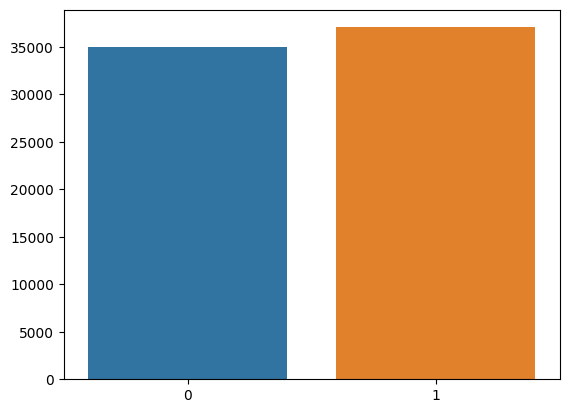

In [ ]:
#Counting the total number of labels
label_counts = df['label'].value_counts()
#Calculating the percentage of each label
label_percentages = 100 * label_counts / label_counts.sum()
#Plotting the graps and displaying the percentages
print('percentage of each label:')
print(label_percentages)
sns.barplot(x=label_counts.index, y=label_counts.values)


The dataset might contain duplicated entries hence it's important remove such entries as this has the potential to introduce a bias in the model.

In [ ]:
#Checking if there are any duplicated values
df.duplicated().sum()

0

Due to the limitaion of the computing resources, a part of the of the dataset will be used. The part of the dataset is selected using the sample() function in pandas. This function randomly selects a number of sample of the dataset and attempt's to replicate the original distribution of data.

In [ ]:
#Randomly selection 3500 samples of the original dataset
df=df.sample(3500)

#Checking to see if the same distribution of labels is maintained
label_counts = df['label'].value_counts()
print('The percentage distribution of labels:\n',100 * label_counts / label_counts.sum())

The percentage distribution of labels:
 1    50.857143
0    49.142857
Name: label, dtype: float64


#Text Cleaning

Pre-process is one of the most important steps when working with textual data. Text could contain many unwanted characters symbols which may distort data. These unwanted characters and values need to be removed and replaced appropriately depending on the machine learning model being built.

To build this machine learning model, the text will be used as vectors to classify the news. However care must be taken because unwanted data such as special characters, symbols and emojis which might be interpreted by the model as a feature. The column will need to be checked for special characters, hashtags and mentions(@) as well as with URLs, if found these will need to be removed.

To check the unwanted characters, symbols and emojis in the text, the pandas str.contains method is used to identify if the string contains any wide range of Unicode characters commonly used. This returns a boolean expression if any of these are found.

In [ ]:
#Checking if the column containes any special characters, symbols or emojis
df['text'].str.contains('[\U0001F000-\U0001FFFF]', flags=re.UNICODE).value_counts()

False    3495
True        5
Name: text, dtype: int64

The syntax above returned true for 5 such characters in the 'text' column. These will be removed and replaced with and empty string using str.replace method in pandas. Running the previous syntax again to see if these special were removed and replaced with an empty string which gives a False value for all the text in the 'text' column indicating that theses special characters were removed.

In [ ]:
df['text']=df['text'].str.replace('[\U0001F000-\U0001FFFF]',' ',regex=True)
df['text'].str.contains('[\U0001F000-\U0001FFFF]', flags=re.UNICODE).value_counts()

False    3500
Name: text, dtype: int64

To check for URLs which may be interrupted as a feature during feature engineering part, the same syntax is used display the total number of strings that contain http or www.

In [ ]:
links=((df['text'].str.contains('http'))|(df['text'].str.contains('www'))).sum()
print('total number of URLs:',links)

total number of URLs: 285


The above links variable showed that there were 285 instances of URLs within the 'text' column. These will be removed and replaced with empty string using the regular expression library of pandas. In the below syntax, the lambda function is applied to the 'text' column that replaces the the http, www and a sequence of digits with an empty string. To see if the URLs were successfully removed the above syntax is run again to check.

In [ ]:
df['text'] = df['text'].apply(lambda text: re.sub(r"http\S+|www\S+|\d+", "", text))
links=((df['text'].str.contains('http'))|(df['text'].str.contains('www'))).sum()
print('total number of URLs:',links)

total number of URLs: 0


Next the 'text' column is checked if it contains hastags and mentions(@) using the same pandas contains() method and the sum of them is printed. This returns the sum of the hashtags and mentions(@)

In [ ]:
#Checking if the 'text' column contains # and @
hashtags = df['text'].str.contains('#')
mentions = df['text'].str.contains('@')
print('Number of hastags:',mentions.sum())
print('Number of mentions(@):',hashtags.sum())

Number of hastags: 555
Number of mentions(@): 242


The number of hashtags and mentions is 555 and 242 respectively. Just like removing the URLs in the column, the regular expression library of pandas is used to substitute hashtags and mentions with empty string. the hastags and mentions variables are then checked to see if the code executed successfully.

In [ ]:
df['text'] = df['text'].apply(lambda text: re.sub(r'[^\w\s]', '', text))
hashtags = df['text'].str.contains('#')
mentions = df['text'].str.contains('@')
print('Number of hastags:',mentions.sum())
print('Number of mentions(@):',hashtags.sum())

Number of hastags: 0
Number of mentions(@): 0


# Words and Sentence Pre-processing
Natural language processing machine learning models analyze words instead of sentences. However the problem with this is that these models may attach varying importance to the same word depending on its spelling and grammatical. It might also use attach meaning to stop words, these are commonly used in sentences but don't carry much meaning. Words like 'is','the' and 'in' add to the size of a the corpus in natural language processing but information from these words are negligible. There are various steps that will be taken to attempt to negate these problems. The first step in word and sentence pre-processing for this model is the removal of stop words.


To remove the stop words the natural language toolkit library (nltk) will be used. The toolkit will remove the stop words that match the ones in nltk's corpus from the 'text' column and replaced them with an empty string.

Before any preprocessing techniques are used, the words need to be in lower case so that all the words are in a uniform format. Next all the stop words are removed from the 'text' column. Once done, the words will need to be separted from the sentences. To separate the words, nltk's tokenizer will be used. This will separate the words into individual tokens.  The words will then be stemmed to reduce them to their base root. Stemming just removes the portion of the word. This is an important step prior to converting the text into numerical data as the conversion may interpret the same word with different grammatical usage and two separate words. This pre-process will be carried out using a function which will take the text as an argument. The function is defined as a pre-process and the text that is entered, all the letters are transformed to a lowercase. Nltk's natural language toolkit then removes all the stop words and the same libarary's tokenizer utility then used to tokenize the text. The text is then stemmed using and nltk's porter stemmer. Finally the words are without any stop words, lower cased, tokenized and stemmed are then joined again. In the data frame a new column is created called 'processed'. To only apply the function to only the 'text' column, the apply() function is used.

In [ ]:
#Defining a  function
def pre_process(text):

    #Turning all the text to lowercase
    text = text.lower()

    #Importing a list of stop words
    stop = stopwords.words('english')
    #Removing stop words from the 'text' column
    text = ' '.join([word for word in text.split() if word not in (stop)])

    #Tokenizing the text and assigning it to a variable
    words = nltk.word_tokenize(text)

    #Initializing the PortmerStemmer function
    stemmer = nltk.stem.porter.PorterStemmer()

    #Stemming the words in the text using list comprehension
    stemmed_words = [stemmer.stem(w) for w in words]

    #Joining the lowercased, tokeized and stemmed words
    return " ".join(stemmed_words)

#Applying the pre-process function to only the 'text' column of the data frame
df['processed'] = df['text'].apply(pre_process)
df.head()

,Unnamed: 0,title,text,label,processed
35016,35016,NaN,Hyperbole is odious\nThis is not a bad article...,1,hyperbol odiou bad articl part titl america su...
52000,52000,International observers will watch U.S. vote c...,VIENNA Reuters Amid charges from Donald Trump...,0,vienna reuter amid charg donald trump us presi...
42827,42827,TED CRUZ Demands We Put Immediate Halt On Plan...,Thank God America has people like Ted Cruz in ...,1,thank god america peopl like ted cruz senat un...
48005,48005,ACCUSED RAPIST BILL CLINTON Has 4 NEW Accusers...,Who didn t see this coming Four more women hav...,1,see come four women come forward charg bill cl...
15975,15975,"Plague kills 124 in Madagascar, cities most af...",KIGALI Reuters A plague epidemic in Madagasca...,0,kigali reuter plagu epidem madagascar kill peo...


# Feature Engineering

Once the text has been cleaned, it needs to be converted into integers because machine learning models cannot recognize words. There are many ways with which this can be done, however, the issue with converting words to integers is that the conversion deprives the words of their meanings and importance. For other tasks such as document classification and information retrieval, converting words into integers suffices. In this case, building a machine learning model that detects fake news, every word has an importance factor attached to it which needs to be represented in the conversion. For this the Term Frequency Inverse Document Frequency (TF-IDF) method is used. This method computes a vector for the term according to its frequency and inverse of document frequency in the entire corpus. Using TF-IDF attaches lesser values to words which are used frequently and higher values to words which are used infrequently. Using TF-IDF preseves and captures the importance of words as compared to just assigning an integer value to each word. TF-IDF also normalizes the values which assists in building a dynamic and efficient machine learning model.  

The 'processed' column with cleaned text was converted to integers using Skit Learn's TF-IDF vectorizer method and assigned to a different variable. The index of the original data frame was then reset and the vectorized data frame was then joined with the original data frame. To evaluate the importance of each word in the model, a dictionary of the words and their respective assigned vector was created which utilized the vocabulary attribute of the TF-IDF method.

In [ ]:
#initializing the function
vectorizer = TfidfVectorizer()
#Passing the processed column to the function and assigning it to a new variable
df_vec = pd.DataFrame(vectorizer.fit_transform(df['processed']).toarray())


#Resetting the index prior joining to ensure alignment with the vectorized
df = df.reset_index(drop=True)


#Joining the 2 datasets
df = pd.concat([df, df_vec], axis=1)

#Mapping the TF-IDF values to words in a dictionary
inverted_index = {term: id for term, id in vectorizer.vocabulary_.items()}

print(df.shape)


(3500, 44659)


Once the text was vectorized, the 'label' column was then taken as the target to predict for the model. A copy of the data frame was created and saved in a seperate variable from which the columns which wont be used in the model training were dropped which produced a new data frame with only float values. These values were then mapped to their corresponding words to the inverted_index dictionary created above and saved in a list.

In [ ]:
#Specifying the prediction target and casting it as a float type
targets=df['label'].values
targets=targets.astype(float)

#Creating a new data frame thats a copy of the original data frame
feats=df.copy()

#Dropping the columns not used in training the model
feats=feats.drop(columns=['Unnamed: 0', 'title', 'text', 'label', 'processed'])

print ('shape of dataset:', feats.shape)
print('number of features:', feats.shape[1])

#Creating and empty list to map the values to the words of the new data frame
feats_list=[]

#Mapping the values of the words and a saveing them in the list
for item in feats.columns:
  if item in inverted_index:
    feats_list.append(inverted_index[item])
  else:
    feats_list.append(item)

features=feats.values
features=features.astype(float)


shape of dataset: (3500, 44654)
number of features: 44654


To train the model the dataset was split into 4 sets with the features assigned to the x value and the target assigned to the y values. Since the dataset was imbalanced data augmentation methods was used to evaluate performance of model on a un-balanced and a balanced data set.

The first split was made using an 80/120 split where 80% of the dataset was split for training and 20% for testing. This resulted in a large train and test set that will be used to train and test the final model. The distribution of classes across the train and test split were maintained using the stratify parameter in Skit Learn's train and test splitting utility.

From the large training set another 80/20 split was made to create a training and validation sets. These training sets will be used to find the best models and the validation sets that will be used to test those models to evaluate their performance.

The last set was creating by splitting the smaller train and test sets created in the previous step. However in this set, data augmentation method was used to balance the data. The data was oversampled to match the minority data to the size of the majority labeled data set.

Due to the limited computing power the datasets could not be undersampled.





In [ ]:
#Splitting the dataset into train and test sets
x_train_lar,x_test,y_train_lar,y_test=(
    sklearn.model_selection.train_test_split(features,targets,test_size=0.20, train_size=.80,stratify=targets))


#Splitting the train and tests sets into validation training and test sets
x_train,x_valid,y_train,y_valid=sklearn.model_selection.train_test_split(
    x_train_lar,y_train_lar,test_size=0.20, train_size=.80, stratify=(
        y_train_lar))

#Creating oversampled train and test sets
x_res_over, y_res_over = SMOTE().fit_resample(x_train,y_train)



# Model Selection

There are many machine learning models that can be utilized, however, their performances differ and vary according the task being carried out. To build the best model the dataset will be evaluated on various models and the best one selected. The hyper-parameters of the best performing model will then be tuned to adjust improve performance and finally the  best model will be trained using the most effective hyper-parameters.

To train and identify the best model and evaluate its performance, the datasets that will be used are the train dataset as well as the resampled dataset since the data is slightly imbalanced. The models are evaluated on both the imbalanced and resampled datasets Even though the data is slightly imabalanced some important features could be missed by the model and will reflect in its performnace on the test set. Due to the limited computing capabilities, the data was only over sampled.

To evaluate the performance of the various models, the validation datasets will be used. The large test dataset will be used as data that the final model has not encountered previosuly and hence can be used as an effective evaluation method of the model's prediction capabilities.

Since the model was imbalanced, the accuracy would be a misleading measure of the model's performance, this is because the model will predict the majority class most of the time which would increase its accuracy. This can be misleading and not a true measure of the model's performance and capability. Since the model is being built to measure its effectiveness in identifying fake news the precision and recall are the main metrics. To identify the best performance across a range of metrics a new metric is taken. This metric is the cubic root of product of the gmean, accuracy and f1 score and called product calculation. The higher the value of product calculation the higher better the performance of the model. The recall and precision metrics are used separately to evaluate the performance of each model and not included in the product calculation.

Several models are evaluated using the above mentioned metrics uing the train and test datasets as well as the over resampled datasets. The model that performed the best across all metrics was then selected.



In [ ]:
#Defining a function to calculate the product
def prod_calc(y_true, y_pred):
    gmean = geometric_mean_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return (gmean * acc * f1) ** (1. / 3)

#Defining a function that will train the models
def apply_model(clf_class, **kwargs):
    clf = clf_class(**kwargs)
    print(clf_class)
    print('--------------------------------------------------')

    #Training the models on imbalaned dataset and evaluating the metrics
    clf.fit(x_train, y_train)
    pred = clf.predict(x_valid)
    gmean = geometric_mean_score(y_valid, pred)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred, average='macro')
    prod = prod_calc(y_valid, pred)
    recall=recall_score(y_valid, pred)
    precision=precision_score(y_valid, pred)
    print('Imbalanced')
    print('G-Mean={:.2f} Accu={:.2f} f1={:.2f}'.format(gmean, acc, f1))
    print('Prod={:.2f} recall={:.2f} prec={:.2f}'.format(prod,recall,precision))

    #Training the models on oversampled dataset and evaluating the metrics
    clf.fit(x_res_over, y_res_over)
    pred = clf.predict(x_valid)
    gmean = geometric_mean_score(y_valid, pred)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred, average='macro')
    prod = prod_calc(y_valid, pred)
    recall=recall_score(y_valid, pred)
    precision=precision_score(y_valid, pred)
    print('\nBalanced')
    print('G-Mean={:.2f} Accu={:.2f} f1={:.2f}'.format(gmean, acc, f1))
    print('Prod={:.2f} recall={:.2f} prec={:.2f}'.format(prod,recall,precision))
    print('\n')



#Training the models selected
def compare_models():
  apply_model(DecisionTreeClassifier)
  apply_model(GradientBoostingClassifier)
  apply_model(RandomForestClassifier)
  apply_model(LinearSVC)
  apply_model(AdaBoostClassifier)
  apply_model(BaggingClassifier)
  apply_model(XGBClassifier)


compare_models()

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
--------------------------------------------------
Imbalanced
G-Mean=0.87 Accu=0.87 f1=0.87
Prod=0.87 recall=0.87 prec=0.88

Balanced
G-Mean=0.87 Accu=0.87 f1=0.87
Prod=0.87 recall=0.87 prec=0.87


<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
--------------------------------------------------
Imbalanced
G-Mean=0.93 Accu=0.93 f1=0.93
Prod=0.93 recall=0.96 prec=0.91

Balanced
G-Mean=0.93 Accu=0.93 f1=0.93
Prod=0.93 recall=0.96 prec=0.90


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
--------------------------------------------------
Imbalanced
G-Mean=0.90 Accu=0.90 f1=0.90
Prod=0.90 recall=0.88 prec=0.92

Balanced
G-Mean=0.90 Accu=0.90 f1=0.90
Prod=0.90 recall=0.88 prec=0.92


<class 'sklearn.svm._classes.LinearSVC'>
--------------------------------------------------
Imbalanced
G-Mean=0.91 Accu=0.91 f1=0.91
Prod=0.91 recall=0.93 prec=0.90

Balanced
G-Mean=0.91 Accu=0.91 f1=0.91
Prod=0.91 recall=0.93 prec=0.9

The Gradient Boosting Classifier and the XGBClassifier were the models that performed the best. The XGBClassifier however was consistent accross all metrics. It exhibited similar performace for both the balanced and imabalnced dataset. The XGBClassifier was then selected as the final model and its hyperparameters were tuned to obtain the best performing model.

# Model Hyper-parameter Tuning

The XGBClassifier is also known as Extreme Gradient Boosting classifier and is a very robust gradient boosting classifier widely used to build classification models. It uses the Decision Tree model and makes use of various gradient boosting algorithms to train of a dataset. Being a very flexible classifier, XGB has various hyperparameters that can be tuned to improve the efficiency of the model. However, due to the limited computing capabilities, only 3 of the hyperparameters were used to tune the model.


In [ ]:
n_estimators=[100,150]
learning_rate=[0.2,0.3]
max_depth=[3,4]

print('Manual grid search results:\n')

max_prod=0
best_hyper_param=[]

for n in n_estimators:
  for r in learning_rate:
    for d in max_depth:
      model=XGBClassifier(n_estimators=n, learning_rate=r,max_depth=d)
      model.fit(x_train,y_train)
      pred=model.predict(x_valid)
      prod=prod_calc(y_valid,pred)
      acc=accuracy_score(y_valid,pred)
      recall=recall_score(y_valid, pred)
      precision=precision_score(y_valid, pred)
      print('n_etimators = {:},learning_rate = {:} max_depth = {:}'.format(n,r,d))
      print('----------------------------------------------------------')
      print('product = {:.2f}, accuracy = {:.2f}'.format(prod,acc))
      print('precision={:.2f}, recall={:.2f}\n'.format(precision,recall))



      if prod>max_prod:
        max_prod=prod
        best_hyper_params=[n,r,d]

print('=========================================================================')
print('The best hyper-parameters are:\n')
print('n_estimators = {:3d}|learning_rate={:.2f}|max_depth={:2d}| product={:.2f}'.format(best_hyper_params[0], best_hyper_params[
    1], best_hyper_params[2], prod))

Manual grid search results:

n_etimators = 100,learning_rate = 0.2 max_depth = 3
----------------------------------------------------------
product = 0.93, accuracy = 0.93
precision=0.92, recall=0.95

n_etimators = 100,learning_rate = 0.2 max_depth = 4
----------------------------------------------------------
product = 0.93, accuracy = 0.93
precision=0.93, recall=0.93

n_etimators = 100,learning_rate = 0.3 max_depth = 3
----------------------------------------------------------
product = 0.92, accuracy = 0.92
precision=0.91, recall=0.93

n_etimators = 100,learning_rate = 0.3 max_depth = 4
----------------------------------------------------------
product = 0.93, accuracy = 0.93
precision=0.93, recall=0.93

n_etimators = 150,learning_rate = 0.2 max_depth = 3
----------------------------------------------------------
product = 0.93, accuracy = 0.93
precision=0.92, recall=0.94

n_etimators = 150,learning_rate = 0.2 max_depth = 4
----------------------------------------------------------


# Building the Model

Once the best hyperparameters were identified, the XGBClassifier model was trained using the large training sets.

In [ ]:
#Training the model using the best hyperparameters identified
model= XGBClassifier(n_estimators = 150,learning_rate=0.20,max_depth= 4)
clf=model.fit(x_train_lar, y_train_lar)
display(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Model Evaluation

The trained model's performance was then evaluted using the test sets. Since the model was required to identify if a news article is fake or not (labeled 0 for fake and 1 for real), the important evaluation parameters were precision and recall. This is because identifying a fake news article is critical so that it does not show up on the app. Precision is the number of true positives compared to the predicted positive predictions made by the model. Recall is a measure of how well the model identifies the each instance. The trained model has a precision of 94% in identifying fake news articles which translates to a low false positive rate, where the news article is real but the model flagged it as fake. The model also has a recall of 92% when it predicts fake news articles. this means that the model correctly predicted fake news 92% of the time.  

In [ ]:
#Evaluating the model on the test sets
y_pred=clf.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       344
         1.0       0.92      0.95      0.93       356

    accuracy                           0.93       700
   macro avg       0.93      0.93      0.93       700
weighted avg       0.93      0.93      0.93       700



The confusion matrix builds on the classification report above and shows the performance of the model on the test set. The model predicted and identified 315 of the fake news articles correctly and 337 of the real news articles correctly. According to the confusion matrix the model performed reasonable well, however there is room for improvement that will be discussed in the conclusion section below.

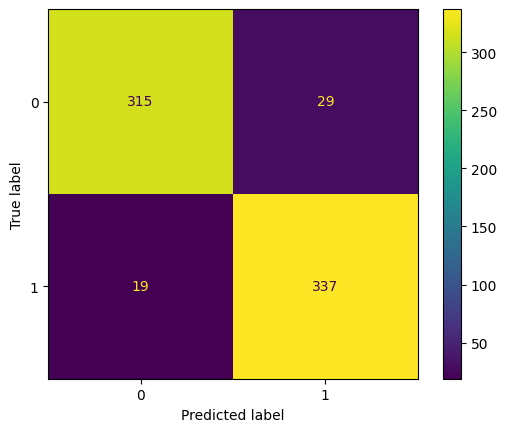

In [ ]:
#Displaying the confusion matrix for the predicted values
y_pred=clf.predict(x_test)
cm=sklearn.metrics.confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cm).plot()

To evaluate the most important features used by the model, the model's feature importance attribute of the model was utilized. This was matched to the list of features created in the feature engineering section. The top 15 features that the model considered important in its training are plotted below. From the plot it can be seen that the model considered Mr. as a very important feature and attached a high importance to it. The plot also includes some stop words that were not completely removed from the set and model but were so rare across the dataset that the model attached high importance to them.

Top 15 important features:


<Axes: >

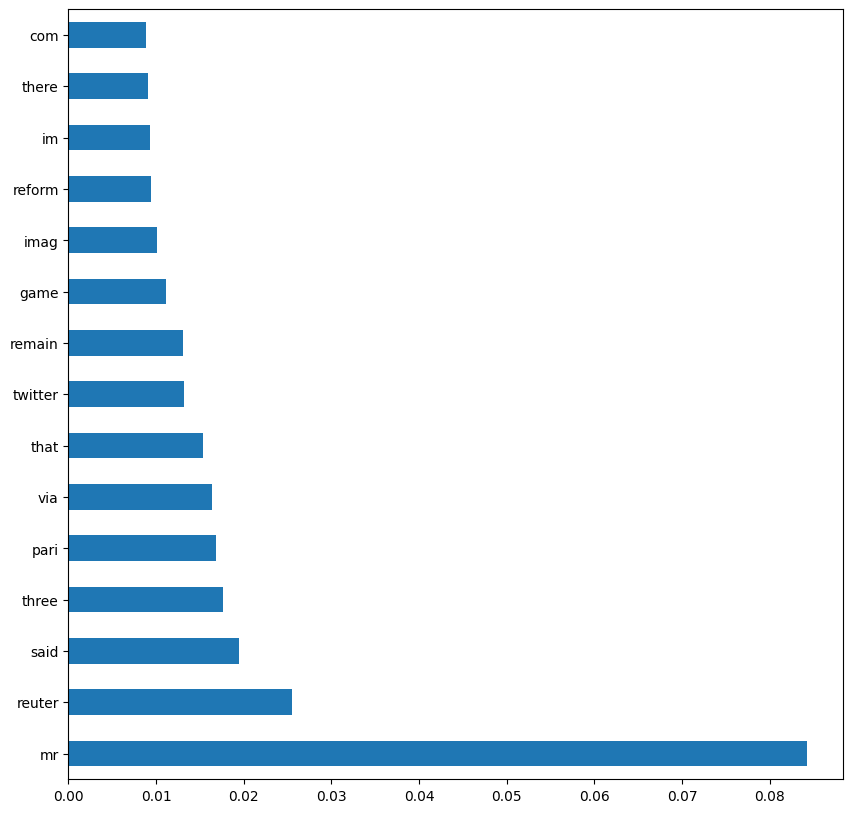

In [ ]:
Top_n = 15
print('Top', Top_n, 'important features:')
feat_importance = pd.Series(clf.feature_importances_, index=feats_list)
feat_importance = feat_importance.nlargest(Top_n)

# Get the feature names from inverted_index
feature_names = [key for key, value in inverted_index.items() if value in feat_importance.index]

feat_importance.index = feature_names

feat_importance.plot(kind='barh', figsize=(10, 10))

# Conclusion

The trained model exhibited a reasonably high degree of accuracy in identifying and predicting articles that were fake news. The dataset was slightly imbalanced however, when evaluating various models, there was little difference in performance when compared to the ones evaluated on an oversampled dataset. A more comprehensive evaluation could be made if the models were evaluated using both the over and under sampled dataset. The model's accuracy could be further increased if a larger subset was taken which may contain more important features allowing the model to make predictions and with a higher degree of precision. A more effective and powerful stop word removal utility could be used to remove all the stop words that were found so that the model does not interpret them as an important feature.